## Monoxor ML Intern Task 

In [1]:
# Module imports 
import pandas as pd, numpy as np, re
import warnings,nltk,joblib,json
from nltk.corpus import stopwords
from tqdm import tqdm
from os import path
from scipy import spatial
nltk.download('stopwords')
from IPython.display import clear_output
warnings.filterwarnings("ignore")
from sklearn.metrics import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
clear_output()

In [2]:
from collections import MutableMapping  

def json_to_frame(data):
    
    """Function to convert data from json to dataframe """
    
    def convert_flatten(d, parent_key ='', sep ='_'): 
        
        """Funtion to flatten a nested dictionary"""
        
        items = [] 
        for k, v in d.items(): 
            new_key = parent_key + sep + k if parent_key else k 
    
            if isinstance(v, MutableMapping): 
                items.extend(convert_flatten(v, new_key, sep = sep).items()) 
            else: 
                items.append((new_key, v)) 
        return dict(items)

    lst_dict=[]
    for i in data:
        lst_dict.append(convert_flatten(i))
    df = pd.DataFrame(lst_dict)
    return df

# Reading data from a json file
if path.exists("data.json"): 
    with open('data.json') as f:
        data = json.load(f)
    df=json_to_frame(data)

df.head(2) # top 2 rows of dataframe

,req_baseUrl,req_body_note_title,req_body_note_desc,req_fresh,req_headers_host,req_headers_user-agent,req_headers_content-type,req_headers_org_id,req_headers_user_session_id,req_headers_accept,req_headers_content-length,req_headers_user_name,req_headers_user_role,req_hostname,req_ip,req_ips,req_originalUrl,req_path,req_protocol,req_secure,req_stale,req_subdomains,req_xhr,isSafe
0,/crm/note,Tina Johnson,Top recognize eat. Fact whom spend area thing ...,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,True
1,/crm/note,Clayton Cooper,As possible American many prepare four strong....,False,example.com,insomnia/2020.4.2,application/json,5f572820f65af8ac955b2e83,5fb27d3750b11901a35649fe,*/*,70,sam,sales1,example.com,::ffff:117.99.96.244,[],/crm/note,/note,http,False,True,[crm],False,True


In [3]:
df.columns # Features in dataframe

Index(['req_baseUrl', 'req_body_note_title', 'req_body_note_desc', 'req_fresh',
       'req_headers_host', 'req_headers_user-agent',
       'req_headers_content-type', 'req_headers_org_id',
       'req_headers_user_session_id', 'req_headers_accept',
       'req_headers_content-length', 'req_headers_user_name',
       'req_headers_user_role', 'req_hostname', 'req_ip', 'req_ips',
       'req_originalUrl', 'req_path', 'req_protocol', 'req_secure',
       'req_stale', 'req_subdomains', 'req_xhr', 'isSafe'],
      dtype='object')

In [4]:
# Value count of all features in dataframe
for i in list(df.columns):
    print(df[i].value_counts()[0:3])
    print("--"*25)

/crm/note    1000
Name: req_baseUrl, dtype: int64
--------------------------------------------------
Michael Smith    3
Heather Davis    2
David Adams      2
Name: req_body_note_title, dtype: int64
--------------------------------------------------
note title <title onPropertyChange title onPropertyChange="javascript:javascript:alert(1)"></title onPropertyChange>    36
Meeting ")) or (("x"))=(("x Notes 12:30                                                                                 33
text1<video src=1 href=1 onerror="javascript:alert(1)"></video>hello                                                    32
Name: req_body_note_desc, dtype: int64
--------------------------------------------------
False    1000
Name: req_fresh, dtype: int64
--------------------------------------------------
example.com    1000
Name: req_headers_host, dtype: int64
--------------------------------------------------
insomnia/2020.4.2    1000
Name: req_headers_user-agent, dtype: int64
--------------------

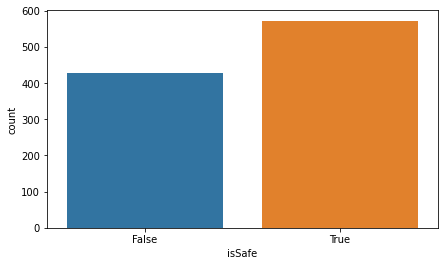

-----------------
isSafe percentage 
-----------------
True     57.2
False    42.8
Name: isSafe, dtype: float64


In [5]:
# ploting count plot of issafe
plt.figure(figsize=(7,4))
sns.countplot(df["isSafe"])
plt.show()
print("-----------------")
print("isSafe percentage ")
print("-----------------")
print(df.isSafe.value_counts() / df.shape[0] * 100)

**observation**:
* The Data contain features with redundent values except for req_body_note_title and req_body_note_desc.
* The only useful feature that can be used with natural language processing for modeling is req_body_note_desc. 
* The Dataset has almost good balance with the amount of number of classes in issafe feature.

In [6]:
def Data_Preprocessing(df,train=False):
    """ Funtion to preprocess data """ 
    final=df.iloc[df.astype(str).drop_duplicates(keep='first').index]
    final.dropna(subset={"req_body_note_title","req_body_note_desc"},inplace=True) 
    final.rename(columns = {'req_body_note_desc':'Text'}, inplace = True)
    if train:final["isSafe"]=final["isSafe"].apply(lambda x: int(x))
    if train:print("1.PRE-PROCESSING   DONE.....(1/5)")
    else:print("1.PRE-PROCESSING   DONE.....(1/3)")
    return final

def Data_Preparation(final, train=False):
    """ funtion for data preparaion """
    stop = set(stopwords.words('english')) 
    sno = nltk.stem.SnowballStemmer('english') 
    def cleanhtml(sentence): # remove all tags
        cleanr = re.compile('<.*?>') 
        cleantext = re.sub(cleanr, ' ', sentence)
        return cleantext
    def cleanpunc(sentence): # remove all puctuations
        cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence) 
        cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
        return  cleaned

    str1, i, s = ' ', 0, ''
    final_string=[]
    for sent in final['Text'].values: # for each row or sentence in data
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove html tags 
        for w in sent.split():  # for each word in sentence
            for cleaned_words in cleanpunc(w).split(): # remove special characters
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):   #  check if string are alphabets
                    if(cleaned_words.lower() not in stop):  # remove string if stop word
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')  # stemming the string
                        filtered_sentence.append(s)  # appending final preprocesed words
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) # append words to get sentence
        final_string.append(str1)   # append preprocessed sentences
        i+=1

    # adding preprocessed data to dataframe
    final.drop(labels='Text', axis="columns", inplace=True)
    final['Text']=final_string
    final['Text']=final['Text'].str.decode("utf-8")
    data, lab = final['Text'], final['isSafe']
    if train:print("2.PREPARING DATA   DONE.....(2/5)")
    else:print("2.PREPARING DATA   DONE.....(2/3)")

    return data, lab

def Train_or_predict(df=None, train=False):

    """ Function to train a LogisticRegression from given data if train==True
        else Function to predict for given test query if train==False  """

    if train:
        
        # Data preparation and processing
        final=Data_Preprocessing(df,True)
        data, lab = Data_Preparation(final,True)

        # train_test_splits for 80:20 splits
        x_train, x_test, y_train, y_test = train_test_split(data,lab, test_size=0.2, random_state=52, stratify=lab)

        # Using vectorizer to get Tfidf Vectors
        tfidf_vect = TfidfVectorizer(ngram_range=(1,2)) 
        train_tfidf = tfidf_vect.fit_transform(x_train)
        test_tfidf = tfidf_vect.transform(x_test)
        X, y, x_test = train_tfidf, y_train, test_tfidf
        joblib.dump(tfidf_vect,"tfidf_vect")

        # Training GridSearchCV for Hyperparamenter tuning and cross validation
        print("3.TRAINING MODELS  DONE.....(3/5)")
        param_grid = {'C':[0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000,10000], 'penalty':['l2','l1']}
        lr=linear_model.LogisticRegression()
        grid_model = GridSearchCV(lr, param_grid, cv=3, verbose=0, scoring='f1').fit(X,y)
        model = CalibratedClassifierCV(grid_model, cv="prefit").fit(X, y)
        joblib.dump(model,"model")

        # printing grid parameters
        print("4.DATA PREDICTION  DONE.....(4/5)")
        best_C,best_penalty=grid_model.best_params_['C'],grid_model.best_params_['penalty']

        # printing tfidf_vect vectors information
        print("5.PRINTING RESULT  DONE.....(5/5)")
        print("\nSome Features Names from the Document corpus:",tfidf_vect.get_feature_names()[60:63])
        print("TFIDF vectorizer Shape:{1} \nTotal No of unique words in Document corpus:{0} \n".format(train_tfidf.get_shape()[1],train_tfidf.get_shape()))

        # checking shapes of splits
        print("Dataset Split sizes in vector form")
        print("x-train: {0}    y-train: {2}    \nx-test:  {1}    y-test:  {3}".format(train_tfidf.shape,test_tfidf.shape,y_train.shape,y_test.shape))

        print("\nGRID-CROSS-VALIDATION") # Best cross validation parameters
        print("BEST CV_PARAMETERS: ",grid_model.best_params_)
        print("BEST CV_SCORE: ",np.round(grid_model.best_score_,4))
        
        print("\nTEST SET SCORES") # Test split results
        print("F1-Score of test set:  {0:.4f}".format((f1_score(y_test,model.predict(x_test)))))
        print("Precision of test set: {0:.4f}".format((precision_score(y_test,model.predict(x_test)))))
        print("Recall of test set:    {0:.4f}".format((recall_score(y_test,model.predict(x_test)))))
        print("AUC Score test set:    {0:.4f}".format(roc_auc_score(y_test,model.predict_proba(x_test)[0:,-1:])))

        # Refit with best parameters for data
        model=linear_model.LogisticRegression(C=best_C,penalty=best_penalty).fit(tfidf_vect.fit_transform(data), lab)
        a=tfidf_vect.get_feature_names()  # tfidf feature names
        coef=model.coef_[0]  # get model coefficients 
        coef_sorted=coef.argsort() # sort model coefficients 
        safe,unsafe=coef_sorted[-10:],coef_sorted[0:10]        
        
        pos_features_names=np.take(a,safe)    # obtain top safe words 
        print("\nTOP 10 SAFE FEATURES")    
        print(list(pos_features_names))

        neg_features_names=np.take(a,unsafe)  # obtain top unsafe words
        print("\nTOP 10 UNSAFE FEATURES")
        print(list(neg_features_names))

    else:
        
        # Get test query from input prompt and covert to json
        query=[json.loads(input("Enter the json requests here"))]
        if isinstance(query[0],list): query=query[0]
        df=json_to_frame(query)
        clear_output(wait=True)

        # Query Preprocessing and Preparation 
        final=Data_Preprocessing(df)
        data, lab = Data_Preparation(final)
        
        # load joblib models and tfidf object
        tfidf_vect,model=joblib.load("tfidf_vect"),joblib.load("model")
        query_tfidf = tfidf_vect.transform(data) # Query Vectorization
        isSafe=list(model.predict(query_tfidf)) # model prediction
        for k in range(len(isSafe)): # encoding prediction result
            isSafe[k]= True if isSafe[k]==1 else False
        print("3.DATA PREDICTION  DONE.....(3/3)")
        return isSafe

##### Funtion call for Model training ( No need to run this cell )

In [7]:
# Funtion call to train
isSafe=Train_or_predict(df,train=True)

1.PRE-PROCESSING   DONE.....(1/5)
2.PREPARING DATA   DONE.....(2/5)
3.TRAINING MODELS  DONE.....(3/5)
4.DATA PREDICTION  DONE.....(4/5)
5.PRINTING RESULT  DONE.....(5/5)

Some Features Names from the Document corpus: ['across former', 'across marriag', 'across newspap']
TFIDF vectorizer Shape:(800, 11799) 
Total No of unique words in Document corpus:11799 

Dataset Split sizes in vector form
x-train: (800, 11799)    y-train: (800,)    
x-test:  (200, 11799)    y-test:  (200,)

GRID-CROSS-VALIDATION
BEST CV_PARAMETERS:  {'C': 10, 'penalty': 'l2'}
BEST CV_SCORE:  0.8621

TEST SET SCORES
F1-Score of test set:  0.8692
Precision of test set: 0.7740
Recall of test set:    0.9912
AUC Score test set:    0.8168

TOP 10 SAFE FEATURES
['rest', 'student', 'custom', 'democrat', 'tabl', 'phone', 'state', 'although', 'manag', 'nation']

TOP 10 UNSAFE FEATURES
['note', 'hello', 'meet note', 'note titl', 'titl', 'artist', 'accord', 'simpl', 'teach', 'check']


#### Function call to predict for test query ( Run below cell with new request query )

In [7]:
# function call to predict for test query
isSafe=Train_or_predict()
print("\nisSafe Predictions :",isSafe)

1.PRE-PROCESSING   DONE.....(1/3)
2.PREPARING DATA   DONE.....(2/3)
3.DATA PREDICTION  DONE.....(3/3)

isSafe Predictions : [True]


#### Query Example below to Run a test (copy and paste as input for above cell)

In [ ]:
{
    "req": {
      "baseUrl": "/crm/note",
      "body": {
        "note": {
          "title": "Tina Johnson",
          "desc": "Top recognize eat. Fact whom spend area thing material.\nWar no recent also message four billion. Water those deep.\nWord amount table entire. Drug several the amount live newspaper."
        }
      },
      "fresh": false,
      "headers": {
        "host": "example.com",
        "user-agent": "insomnia/2020.4.2",
        "content-type": "application/json",
        "org_id": "5f572820f65af8ac955b2e83",
        "user_session_id": "5fb27d3750b11901a35649fe",
        "accept": "*/*",
        "content-length": "70",
        "user": {
          "name": "sam",
          "role": "sales1"
        }
      },
      "hostname": "example.com",
      "ip": "::ffff:117.99.96.244",
      "ips": [],
      "originalUrl": "/crm/note",
      "params": {},
      "path": "/note",
      "protocol": "http",
      "query": {},
      "secure": false,
      "stale": true,
      "subdomains": [
        "crm"
      ],
      "xhr": false
    },
    "isSafe": "Predict_this_value"
  }